In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
import copy

# Hyperparameters
N = 100  # number of RNN units
dt = 0.15  # time step
T_train = 300  # shorter training sequence length
T_eval = 1000  # evaluation sequence length
#n_bits = 3  # 3-bit memory
pulse_prob = 0.01  # probability of pulse per bit per timestep
noise_std = 0.015  # standard deviation of noise added to hidden state during training

# Define the RNN dynamics class
class ContinuousRNN(nn.Module):
    def __init__(self, N, n_bits):
        super(ContinuousRNN, self).__init__()
        self.N = N
        self.n_bits = n_bits
        self.input_weights = nn.Parameter(torch.randn(N, n_bits) * 0.1)
        self.recurrent_weights = nn.Parameter(torch.randn(N, N) * 0.1 * 1.0)
        self.output_weights = nn.Parameter(torch.randn(n_bits, N) * 0.1)
        self.nonlinearity = torch.tanh

    def forward(self, inputs, return_h=False, add_noise=False):
        batch_size, seq_len, _ = inputs.shape
        h = torch.zeros(batch_size, self.N, device=inputs.device)
        outputs = []
        hidden_states = []

        for t in range(seq_len):
            input_t = inputs[:, t, :]
            dh = (-h + self.nonlinearity(
                torch.matmul(h, self.recurrent_weights.T) + torch.matmul(input_t, self.input_weights.T)
            )) * dt
            if add_noise:
                dh += torch.randn_like(h) * noise_std
            h = h + dh
            out = torch.matmul(h, self.output_weights.T)
            outputs.append(out)
            hidden_states.append(h)

        outputs = torch.stack(outputs, dim=1)
        hidden_states = torch.stack(hidden_states, dim=1)

        if return_h:
            return outputs, hidden_states
        else:
            return outputs
        
def generate_batch(batch_size, T, n_bits, pulse_prob, device='cpu'):
    inputs = torch.zeros(batch_size, T, n_bits, device=device)
    targets = torch.zeros(batch_size, T, n_bits, device=device)

    # Current state per bit per sample
    current_input = torch.zeros(batch_size, n_bits, device=device)
    memory = torch.zeros(batch_size, n_bits, device=device)

    for t in range(T):
        # Decide which bits start a new pulse
        start_mask = (current_input == 0) & (torch.rand(batch_size, n_bits, device=device) < pulse_prob)

        # Random ±1 for new pulses
        new_pulses = (torch.randint(0, 2, (batch_size, n_bits), device=device) * 2 - 1).float()

        # Apply new pulses
        current_input[start_mask] = new_pulses[start_mask]
        memory[start_mask] = current_input[start_mask]  # update memory only on new pulses

        # Decide which bits return to 0
        stop_mask = (current_input != 0) & (torch.rand(batch_size, n_bits, device=device) < 0.05)
        current_input[stop_mask] = 0.0

        # Store values
        inputs[:, t, :] = current_input
        targets[:, t, :] = memory

    return inputs, targets

def load_rnn(save_path, device=None):
    """
    Loads a ContinuousRNN from disk, reconstructing it completely.
    Returns the model in eval() mode.
    
    Args:
      save_path (str): path to .pth file saved by save_rnn.
      device (torch.device or str, optional): where to load the weights;
        if None, defaults to CPU.
    """
    # 1) Load checkpoint
    device = device or torch.device('cpu')
    ckpt = torch.load(save_path, map_location=device)

    # 2) Reconstruct a fresh model
    loaded_rnn = ContinuousRNN(N=ckpt['N'], n_bits=ckpt['n_bits']).to(device)

    # 3) Load the weights
    loaded_rnn.load_state_dict(ckpt['state_dict'])

    # 4) Eval mode
    loaded_rnn.eval()

    print(f"Loaded ContinuousRNN (N={ckpt['N']}, n_bits={ckpt['n_bits']}) from '{save_path}'")
    return loaded_rnn

def randomise_rnn(orig_rnn, reinit_input=False, reinit_rec=False, reinit_output=False, scale=0.1):
    # 1) Deep‐copy the whole model (so you don’t clobber the original)
    new_rnn = copy.deepcopy(orig_rnn)
    
    # 2) Reinitialize the selected Parameter tensors in-place
    with torch.no_grad():
        if reinit_input:
            new_rnn.input_weights.copy_(torch.randn_like(new_rnn.input_weights) * scale)
        if reinit_rec:
            new_rnn.recurrent_weights.copy_(torch.randn_like(new_rnn.recurrent_weights) * scale)
        if reinit_output:
            new_rnn.output_weights.copy_(torch.randn_like(new_rnn.output_weights) * scale)
    return new_rnn

def eval_rnn_specific(rnn, inputs, targets, plot=False):
    # Evaluate on longer sequence
    n_bits = rnn.n_bits
    loss_fn = nn.MSELoss()
    #inputs, targets = generate_batch(1, T_eval, n_bits, pulse_prob)
    outputs, hidden_states = rnn(inputs, return_h=True)
    hidden_states = hidden_states.squeeze(0).detach().cpu().numpy()

    if plot:
        with torch.no_grad():
            loss = loss_fn(outputs[:T_train], targets[:T_train])
            predicted_sign = torch.sign(outputs[:T_train])
            target_sign = torch.sign(targets[:T_train])
            acc = (predicted_sign == target_sign).float().mean()
            print(f"Evaluation Loss: {loss.item():.5f}, Sign Acc: {acc.item() * 100:.2f}%")

        plt.figure(figsize=(15, 8))
        for i in range(n_bits):
            plt.subplot(n_bits, 1, i+1)
            plt.plot(inputs[0, :, i], label="Input", linestyle=':', alpha=0.5)
            plt.plot(targets[0, :, i], label="Target", linestyle='-', alpha=0.9)
            #plt.plot(outputs[:, i], label="Output", linestyle='--', alpha=0.9)
            plt.plot(outputs.squeeze(0).detach().cpu().numpy()[:, i], label='Output', linestyle='--', alpha =0.9)
            plt.legend()
            plt.title(f'Bit {i+1}')
        plt.tight_layout()
        plt.show()

    return hidden_states

In [2]:
threebitrnn = load_rnn("/home/davio/models/threebitrnn.pth")
twobitrnn = load_rnn("/home/davio/models/twobitrnn.pth")
twobitrnnseed444 = load_rnn("/home/davio/models/twobitrnnseed444.pth")
twobit1000 = load_rnn("/home/davio/models/twobit1000.pth")
twobit1000seed66 = load_rnn("/home/davio/models/twobit1000seed66.pth")
twobit2500 = load_rnn("/home/davio/models/twobit2500.pth")
twobitallrandom = randomise_rnn(twobitrnn, reinit_input=True, reinit_rec=True, reinit_output=True)
twobitrecrandom = randomise_rnn(twobitrnn, reinit_rec=True)
threebitallrandom = randomise_rnn(threebitrnn, reinit_input=True, reinit_rec=True, reinit_output=True)

Loaded ContinuousRNN (N=100, n_bits=3) from '/home/davio/models/threebitrnn.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/home/davio/models/twobitrnn.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/home/davio/models/twobitrnnseed444.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/home/davio/models/twobit1000.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/home/davio/models/twobit1000seed66.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/home/davio/models/twobit2500.pth'


In [137]:
import torch
import itertools
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_flip_inputs(device, T=1000, pulse_t=150, k=3, n_bits=3):
    # --- 1) Generate all single‐bit flip trajectories ---
    #flip_trajectories = []
    # all 8 memory patterns
    input_list = []

    for pattern in itertools.product([-1.0, 1.0], repeat=n_bits):
        base = torch.tensor(pattern, device=device).view(1, n_bits)
        for bit in range(n_bits):
            # build inputs: start at `base`, no input until the flip, then flip that bit
            inputs = torch.zeros(1, T, n_bits, device=device)
            inputs[0, 0, :] = base
            inputs[0, pulse_t, bit] = -base[0, bit]
            input_list.append(inputs)
            # run RNN
            #outputs, hs = rnn(inputs, return_h=True)   # hs: (1, T, N)
            #hs = hs.squeeze(0).detach()                # (T, N)
            
            #flip_trajectories.append({
            #    'pattern': pattern,
            #    'bit': bit,
            #    'hidden': hs
            #})
            #flip_trajectories.append(hs)

        init_indices = [pulse_t - 1, pulse_t + 1, T - 1]

    return input_list, init_indices

def get_perimeter_input(device, T_per=300, pulse_width=5 , pulse_offset=50, T_buffer=100, n_bits=2):
    """
    Generate a single trajectory that starts at (0, 0), sets memory to (+1, +1),
    then traverses the perimeter of the square with one bit-flip per segment.
    Returns input [1, T, n_bits], full-length targets [1, T, n_bits], and sampling indices.
    """
    assert n_bits == 2, "Only 2-bit perimeter traversal supported."

    # States to traverse: one bit changes per step (Hamming distance = 1)
    perimeter_states = [
        [+1, +1],  # initial state
        [-1, +1],
        [-1, -1],
        [+1, -1],
        [+1, +1]   # close the loop
    ]

    num_transitions = len(perimeter_states) - 1
    T_total = T_buffer + T_per * (num_transitions + 1)  # extra segment for initialisation
    inputs = torch.zeros(1, T_total, n_bits, device=device)
    targets = torch.zeros(1, T_total, n_bits, device=device)
    init_indices = []

    # === 1) Initial pulse to (+1, +1) ===
    t_start = T_buffer
    t_pulse = t_start + pulse_offset
    inputs[0, t_pulse : t_pulse + pulse_width, :] = +1  # pulse both bits ON
    targets[0, t_start : t_start + T_per, :] = torch.tensor([+1, +1], device=device)

    init_indices.extend([t_pulse - 1, t_pulse + 1, t_start + T_per - 1])

    # === 2) Traverse perimeter ===
    for i in range(num_transitions):
        curr = torch.tensor(perimeter_states[i], device=device)
        next_ = torch.tensor(perimeter_states[i + 1], device=device)
        flip_bit = (curr != next_).nonzero(as_tuple=True)[0].item()

        t_start = T_buffer + T_per * (i + 1)
        t_pulse = t_start + pulse_offset
        t_late = t_start + T_per - 1

        inputs[0, t_pulse : t_pulse + pulse_width, flip_bit] = -curr[flip_bit]
        targets[0, t_start : t_start + T_per, :] = next_

        init_indices.extend([t_pulse - 1, t_pulse + 1, t_late])

    return torch.cat([inputs], dim=0)  , init_indices, targets
    
def get_hidden_states(rnn, input_list):
    #hidden_states = []
    #for inputs in input_list:
    #    outputs, hs = rnn(inputs, return_h=True)   # hs: (1, T, N)
    #    hs = hs.squeeze(0).detach()                # (T, N)
    #    hidden_states.append(hs)
    
    #return hidden_states
    outputs, hs = rnn(input_list, return_h=True)
    hidden_states = hs.squeeze(0).detach() 
    return hidden_states

def find_fixed_points(rnn, hidden_states, init_indices, T=1000, pulse_t=150, k=3, n_bits=3):
    # --- PARAMETERS ---
    #T = 1000                # sequence length
    #pulse_t = 150      # time of the bit‐flip pulse
    #k = 3                  # number of samples per trajectory: before, after, end
    #n_bits = 3
    device = next(rnn.parameters()).device

    # --- 2) Sample k=3 points from each trajectory ---
    #init_points = []   # list of torch.Tensor shape (1, N)
    #for traj in flip_trajectories:
    #for hs in hidden_states:
        #hs = traj
        #times = [pulse_t - 1, pulse_t + 1, T - 1]  # just before, just after, end
    #    for t in init_indices:
    #        init_points.append(hs[t].view(1, -1))
    init_points = hidden_states[init_indices]

    def find_fixed_point(rnn, h_init, input_t=None, n_iters=500, lr=1e-2):
        h = h_init.clone().detach().to(rnn.input_weights.device).requires_grad_(True)
        optimizer = torch.optim.Adam([h], lr=lr)

        for _ in range(n_iters):
            optimizer.zero_grad()
            input_effective = torch.zeros(1, rnn.n_bits, device=h.device) if input_t is None else input_t
            dh = (-h + torch.tanh(h @ rnn.recurrent_weights.T + input_effective @ rnn.input_weights.T)) * dt
            loss = torch.norm(dh)
            loss.backward()
            optimizer.step()

        return h.detach()

    fixed_points = []
    for h_init in tqdm(init_points):
        #fp = find_fixed_point(rnn, h_init.unsqueeze(0))  # add batch dim
        fp = find_fixed_point(rnn, h_init) 
        fixed_points.append(fp.cpu().numpy())
    

    fixed_points = np.vstack(fixed_points)
    #fixed_points = fixed_points.squeeze(1)

    #return fixed_points, flip_trajectories
    return fixed_points

#fixed_points, flip_trajectories = find_fixed_points(threebitrnn)

In [139]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def classify_fixed_points_dynamics(rnn, fixed_points, dt=dt):
    """
    Classify each fixed point as an attractor, repeller, or saddle
    based on the Jacobian eigenvalues of the autonomous dynamics.
    """
    if not isinstance(fixed_points, torch.Tensor):
        fixed_points = torch.tensor(
            fixed_points, dtype=torch.float32, device=rnn.output_weights.device
        )
    classifications = []
    for h_fp in fixed_points:
        h_fp = h_fp.detach().requires_grad_(True)
        input_t = torch.zeros(rnn.n_bits, device=h_fp.device)
        def dynamics(h):
            return (-h + torch.tanh(
                        h @ rnn.recurrent_weights.T +
                        input_t @ rnn.input_weights.T
                   )) * dt
        J = torch.autograd.functional.jacobian(dynamics, h_fp)
        eigvals = torch.linalg.eigvals(J).cpu().numpy()
        real_parts = eigvals.real
        n_pos = (real_parts > 0).sum()
        n_neg = (real_parts < 0).sum()
        if n_pos == 0:
            classifications.append("attractor")
        elif n_neg == 0:
            classifications.append("repeller")
        else:
            classifications.append("saddle")
    return classifications

def classify_memory_states(fixed_points, rnn):
    """
    Determine the ±1 memory pattern read out at each fixed point.
    """
    if not isinstance(fixed_points, torch.Tensor):
        fixed_points = torch.tensor(
            fixed_points, dtype=torch.float32, device=rnn.output_weights.device
        )
    else:
        fixed_points = fixed_points.to(device=rnn.output_weights.device)
    with torch.no_grad():
        outputs = fixed_points @ rnn.output_weights.T
        return torch.sign(outputs).cpu().numpy()

def classify_memory_states(fixed_points, rnn, tol=0.2):
    """
    Determine the ±1/0 memory pattern at each fixed point by thresholding.
    
    tol: any readout with |z|<tol will be labeled 0, otherwise ±1.
    """
    # get outputs [n_fp, n_bits]
    if not isinstance(fixed_points, torch.Tensor):
        fixed_points = torch.tensor(
            fixed_points, dtype=torch.float32, device=rnn.output_weights.device
        )
    else:
        fixed_points = fixed_points.to(rnn.output_weights.device)

    with torch.no_grad():
        z = fixed_points @ rnn.output_weights.T             # shape (n_fp, n_bits)
        z = z.cpu().numpy()

    # threshold into -1, 0, +1
    labels = np.zeros_like(z, dtype=int)
    labels[z >  tol] = +1
    labels[z < -tol] = -1
    # labels where |z|<=tol remain 0

    return labels

def memory_pattern_to_string(memory_patterns):
    """
    Convert each ±1 memory pattern into a human-readable string.
    """
    return [' '.join(f"{int(b):+d}" for b in row) for row in memory_patterns]

def view_from_vector(ax, v):
    """
    Given a direction vector v = [vx,vy,vz] in data space (PCA coords),
    set ax.view_init so the camera looks along v.
    """
    # normalize
    v = np.asarray(v, float)
    v = v / np.linalg.norm(v)
    # elevation is angle above the xy-plane:
    elev = np.degrees(np.arcsin(v[2]))
    # azimuth is angle in the xy-plane from the x-axis:
    azim = np.degrees(np.arctan2(v[1], v[0]))
    ax.view_init(elev=elev, azim=azim)

def plot_trajectories(rnn, hidden_states, fixed_points, pca_dim):
    #n_bits = threebitrnn.n_bits
    # 1) Run PCA
    #pca_dim = min(3, n_bits)
    pca   = PCA(n_components = pca_dim)
    #hidden_states = flip_trajectories
    #all_hidden = torch.cat([traj['hidden'] for traj in flip_trajectories], dim=0)
    #all_hidden = torch.cat([traj for traj in flip_trajectories], dim=0)
    #hidden_states = all_hidden.cpu().numpy()  # shape: (8 × 3 trajectories × T, N)
    h_pca = pca.fit_transform(hidden_states.cpu().numpy())  # (T_total × 3)
    #fp_pca = pca.transform(fixed_points.squeeze(1))      # (n_fp × 3)
    fp_pca = pca.transform(fixed_points)      # (n_fp × 3)

    # 2) Classify each fixed point
    memory_states  = classify_memory_states(fixed_points, rnn)
    #memory_labels  = memory_pattern_to_string(memory_states.squeeze(1))
    #dynamics_labels = classify_fixed_points_dynamics(rnn, fixed_points.squeeze(1))
    memory_labels  = memory_pattern_to_string(memory_states)
    dynamics_labels = classify_fixed_points_dynamics(rnn, fixed_points)

    # 3) Prepare colors & markers
    unique_memories, color_indices = np.unique(memory_labels, return_inverse=True)
    cmap       = plt.get_cmap('tab20')
    colors     = [cmap(i) for i in color_indices]
    shape_map  = { "attractor": "o", "saddle": "s", "repeller": "X" }

    # 4) Plot in 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d' if pca_dim == 3 else None)

    if pca_dim == 3:
        ax.plot(h_pca[:, 0], h_pca[:, 1], h_pca[:, 2], color='lightsteelblue', lw=1, label='Trajectory')
        for i, (x, y, z) in enumerate(fp_pca):
            label = f"{memory_labels[i]} ({dynamics_labels[i]})" if memory_labels[i] not in memory_labels[:i] else None
            ax.scatter(x, y, z, color=colors[i], marker=shape_map[dynamics_labels[i]], s=100, label=label)
        ax.set_zlabel("PC3")
    else:
        ax.plot(h_pca[:, 0], h_pca[:, 1], color='lightsteelblue', lw=1, label='Trajectory')
        for i, (x, y) in enumerate(fp_pca):
            label = f"{memory_labels[i]} ({dynamics_labels[i]})" if memory_labels[i] not in memory_labels[:i] else None
            ax.scatter(x, y, color=colors[i], marker=shape_map[dynamics_labels[i]], s=100, label=label)

    step = max(1, len(h_pca) // 50)

    points = h_pca[::step]
    next_points = h_pca[step::step]

    # Make sure both arrays are same length
    if len(points) > len(next_points):
        points = points[:-1]

    dirs = next_points - points

    if pca_dim == 3:
        ax.quiver(
            points[:, 0], points[:, 1], points[:, 2],
            dirs[:, 0], dirs[:, 1], dirs[:, 2],
            length=0.1, normalize=True,
            color='navy', linewidth=0.5, arrow_length_ratio=0.5
        )
    else:
        ax.quiver(
            points[:, 0], points[:, 1],
            dirs[:, 0], dirs[:, 1],
            angles='xy', scale_units='xy', scale=1,
            color='navy', width=0.003,
            headwidth=5, headlength=7, headaxislength=6
        )

    ax.set_title(f"Fixed Points: {pca_dim}D PCA (Colored by Memory, Shaped by Dynamics)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend(loc='best', fontsize='small', frameon=True)

    #i_blue   = memory_labels.index("+1 +1 +1")
    #i_orange = memory_labels.index("+1 +1 -1")
    #mid = (fp_pca[i_blue] + fp_pca[i_orange]) / 2.0

    if pca_dim == 3:
        view_from_vector(ax, [1, 1, 1])
        ax.azim += 10

    plt.tight_layout()
    plt.show()

#plot_trajectories(threebitrnn, flip_trajectories, fixed_points, 3)


Evaluation Loss: 0.26217, Sign Acc: 90.50%


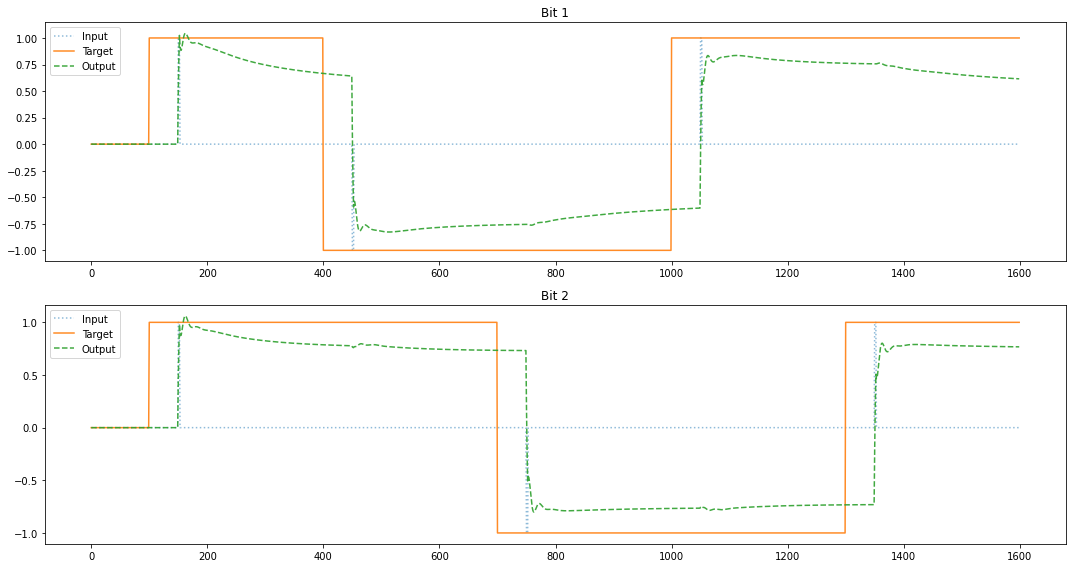

100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


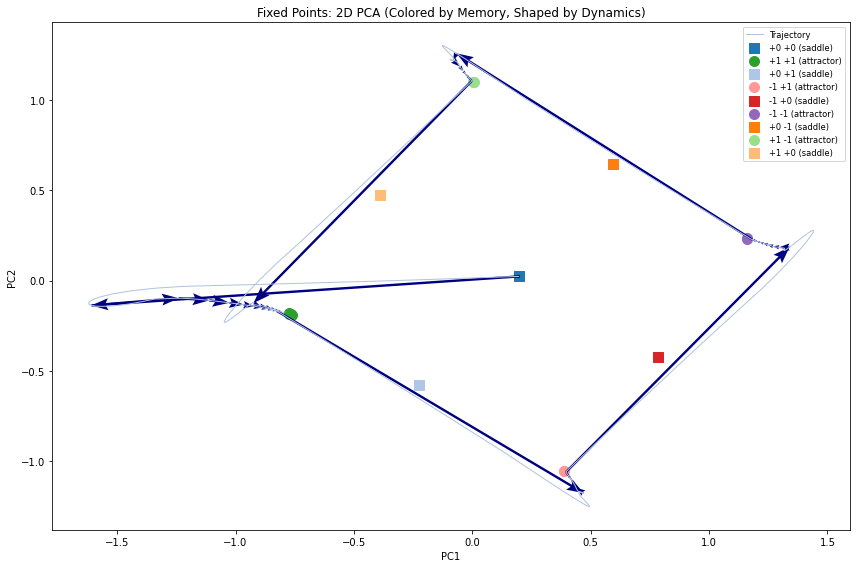

In [140]:
device = next(twobitrnn.parameters()).device
#input_list, init_indices = get_flip_inputs(device, n_bits=2)
input_list, init_indices, targets = get_perimeter_input(device, pulse_width=3, n_bits=2)
#inputs = torch.cat(input_list, dim=0)          # shape: (1, T, n_bits)
#targets = torch.tensor(targets, device=device) # shape: (N, n_bits)
#targets = targets.unsqueeze(1).expand(-1, inputs.shape[1], -1) 
eval_rnn_specific(twobitrnn, input_list, targets, plot=True)
hidden_states = get_hidden_states(twobitrnn, input_list)
fixed_points = find_fixed_points(twobitrnn, hidden_states, init_indices, n_bits=2)
plot_trajectories(twobitrnn, hidden_states, fixed_points, pca_dim=2)

Evaluation Loss: 0.20206, Sign Acc: 90.13%


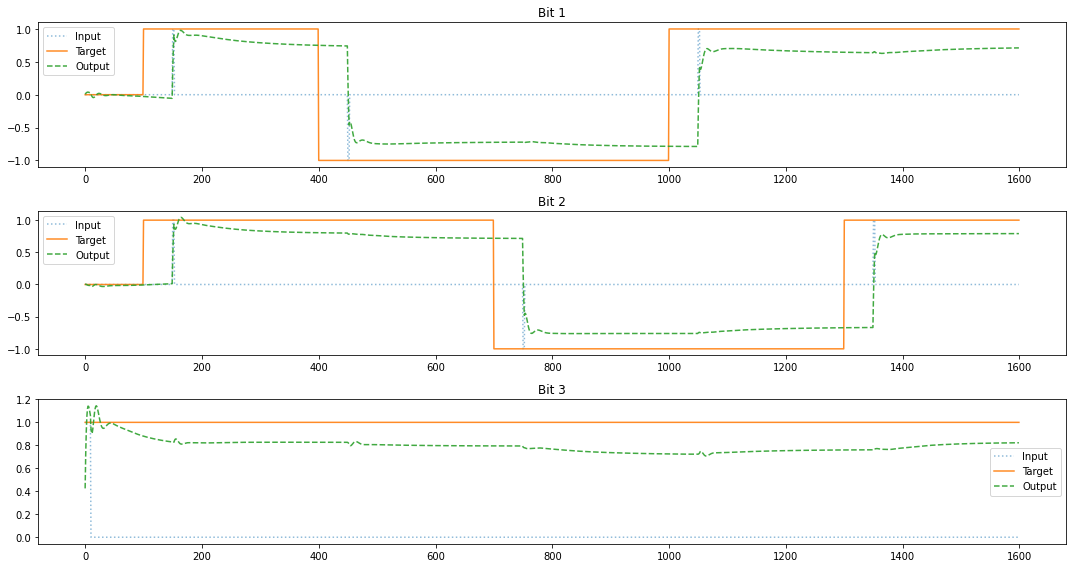

100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


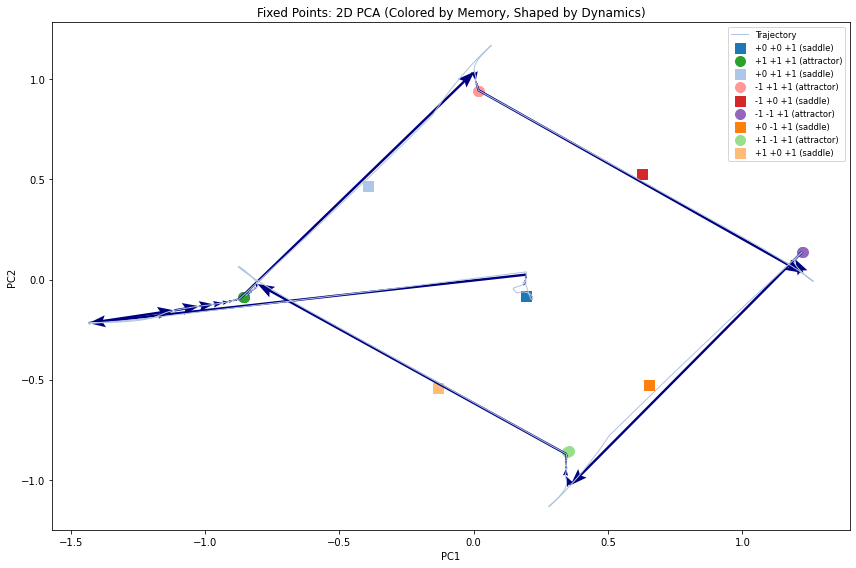

In [143]:
device = next(threebitrnn.parameters()).device
#input_list, init_indices = get_flip_inputs(device, n_bits=2)
input_list, init_indices, targets = get_perimeter_input(device, pulse_width=3, n_bits=2)
zeros   = torch.zeros_like(input_list[..., :1])       # shape (1,500,1)
ones = torch.ones_like(input_list[..., :1]) 
input_list_3bit = torch.cat([input_list, zeros], dim=-1)       # shape (1,500,3)
targets_3bit = torch.cat([targets, ones], dim=-1)       # shape (1,500,3)
input_list_3bit[0, 0:10, 2]   = 1.0
eval_rnn_specific(threebitrnn, input_list_3bit, targets_3bit, plot=True)
hidden_states = get_hidden_states(threebitrnn, input_list_3bit)
fixed_points = find_fixed_points(threebitrnn, hidden_states, init_indices, n_bits=3)
plot_trajectories(threebitrnn, hidden_states, fixed_points, pca_dim=2)

Evaluation Loss: 0.27999, Sign Acc: 90.50%


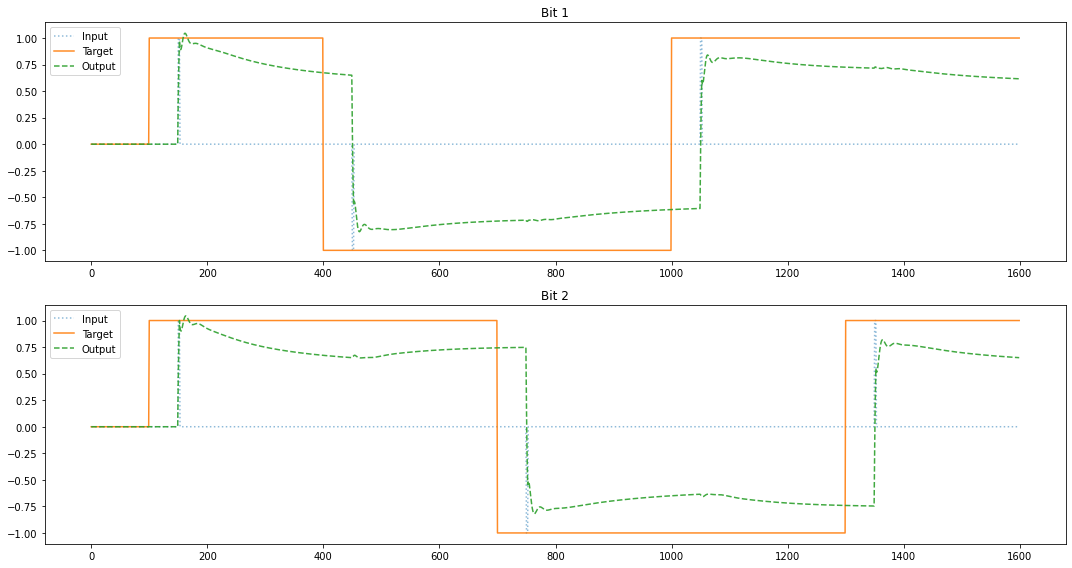

100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


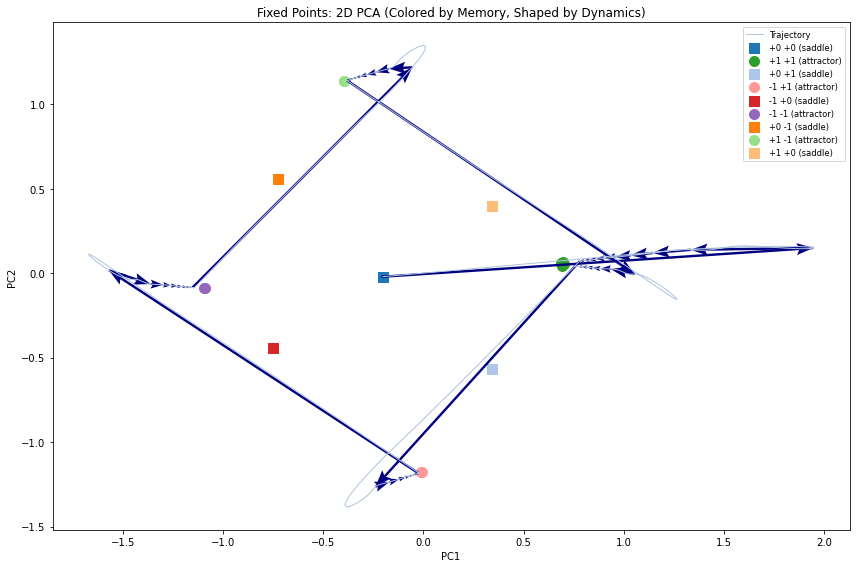

In [125]:
device = next(twobitrnnseed444.parameters()).device
#input_list, init_indices = get_flip_inputs(device, n_bits=2)
input_list, init_indices, targets = get_perimeter_input(device, pulse_width=3, n_bits=2)
inputs = torch.cat(input_list, dim=0)          # shape: (1, T, n_bits)
#targets = torch.tensor(targets, device=device) # shape: (N, n_bits)
#targets = targets.unsqueeze(1).expand(-1, inputs.shape[1], -1) 
eval_rnn_specific(twobitrnnseed444, inputs, targets, plot=True)
hidden_states = get_hidden_states(twobitrnnseed444, input_list)
fixed_points = find_fixed_points(twobitrnnseed444, hidden_states, init_indices, n_bits=2)
plot_trajectories(twobitrnnseed444, hidden_states, fixed_points, pca_dim=2)

Evaluation Loss: 0.91626, Sign Acc: 46.59%


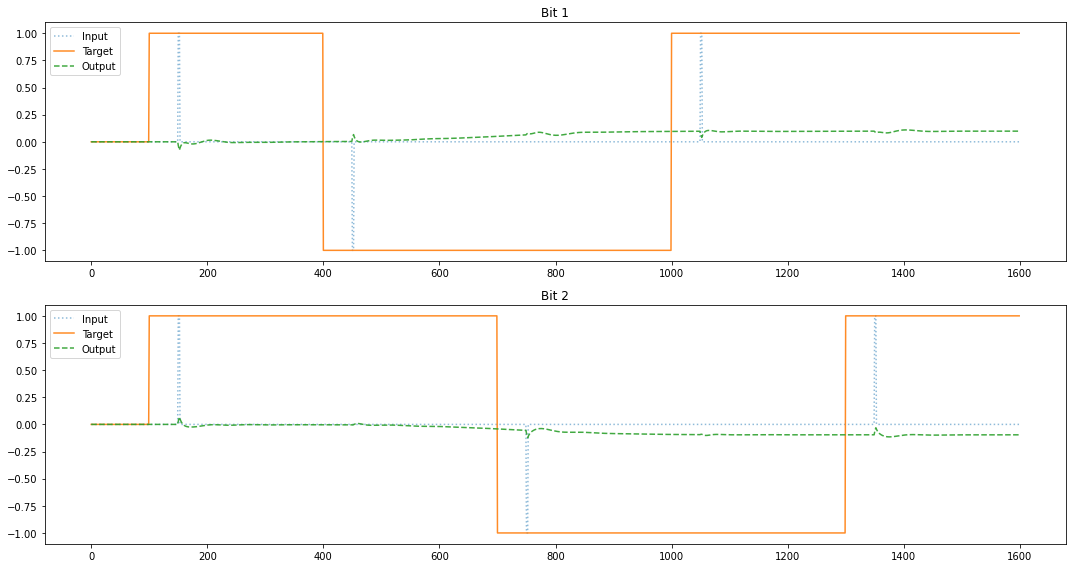

100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


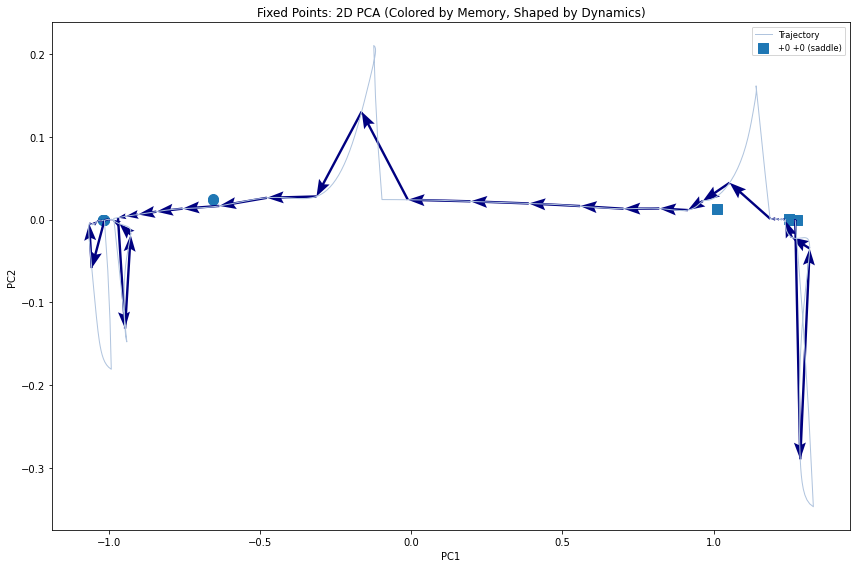

In [126]:
device = next(twobitallrandom.parameters()).device
#input_list, init_indices = get_flip_inputs(device, n_bits=2)
input_list, init_indices, targets = get_perimeter_input(device, pulse_width=3, n_bits=2)
inputs = torch.cat(input_list, dim=0)          # shape: (1, T, n_bits)
#targets = torch.tensor(targets, device=device) # shape: (N, n_bits)
#targets = targets.unsqueeze(1).expand(-1, inputs.shape[1], -1) 
eval_rnn_specific(twobitallrandom, inputs, targets, plot=True)
hidden_states = get_hidden_states(twobitallrandom, input_list)
fixed_points = find_fixed_points(twobitallrandom, hidden_states, init_indices, n_bits=2)
plot_trajectories(twobitallrandom, hidden_states, fixed_points, pca_dim=2)

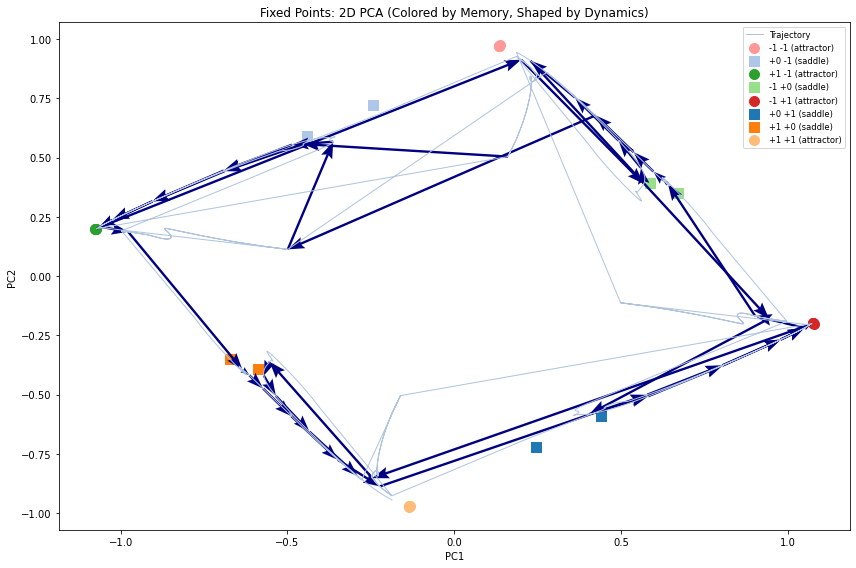

In [82]:
plot_trajectories(twobitrnn, hidden_states, fixed_points, pca_dim=2)

In [59]:
device = next(twobitrnn.parameters()).device
flip_trajectories = get_flip_trajectories(device, n_bits = 2)
twobit_fp, twobit_traj = find_fixed_points(twobitrnn, flip_trajectories, n_bits=2)
plot_trajectories(twobitrnn, twobit_traj, twobit_fp, 2)

NameError: name 'rnn' is not defined

100%|██████████| 24/24 [00:05<00:00,  4.08it/s]


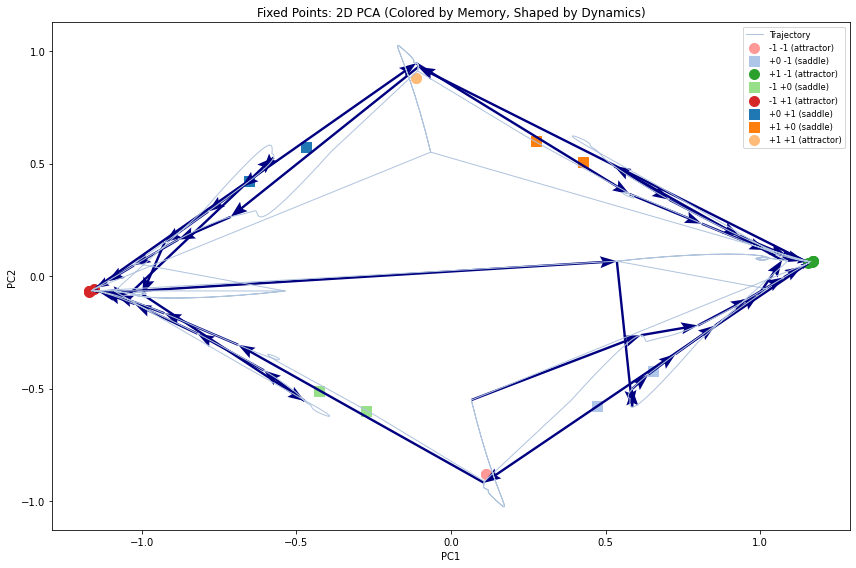

In [51]:
twobit_fp, twobit_traj = find_fixed_points(twobitrnnseed444, n_bits=2)
plot_trajectories(twobitrnnseed444, twobit_traj, twobit_fp, 2)

In [17]:
threebitrnn.n_bits

3